In [65]:
import numpy as np

import matplotlib.pyplot as plt

from multiprocess import Pool
from functools import partial
import numpy as np

import games

import cpb
# import cpb_uniform
import cpb_gaussian

import random_algo

import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures

import synthetic_data
import cpb_side
import cpb_side_gaussian


import gzip
import pickle as pkl

import linucb



def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type, context_type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []
    context_generators = []

    for jobid in range(n_folds):
        
        p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )

        contexts = synthetic_data.QuinticContexts( 2, 0.01)
        context_generators.append( contexts )

        # d = 2
        # margin =0.01
        # contexts = synthetic_data.LinearContexts( np.array([0.5,0.5]), 0, d, margin) #synthetic_data.ToyContexts( )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions , context_generators ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def get_bandit_feedback(self, game, action, outcome):
        return game.banditFeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        distribution, context_generator, jobid = job

        np.random.seed(jobid)

        # outcome_distribution =  {'spam':0.5,'ham':0.5}
        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        #print('optimal action', game.i_star)

        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)
        contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        # context_generator.generate_unique_context()
        # contexts = [ context_generator.get_same_context(outcome) for outcome in outcomes ]

        contexts = np.array(contexts).squeeze()
        contexts = PolynomialFeatures(6).fit_transform( contexts)
        contexts = contexts.tolist()
        dim = len(contexts[0])
        contexts = [ np.array(elmt).reshape( (dim,1) ) for elmt in contexts]

        cumRegret =  np.zeros(self.horizon, dtype =float)

        alg.reset()

        for t in range(self.horizon):

            # if t % 1000 == 0 :
            #     print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]
            context = contexts[t]

            # print(context.T.shape)
            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)
            # print('t', t, 'action', action, 'outcome', outcome, 'context', context)
            
            feedback =  self.get_feedback( game, action, outcome )
            bandit_feedback =  self.get_bandit_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            # print('nu', alg.nu / alg.n )
            regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )
            # print( 'regret:' , regret )
            cumRegret[t] =  regret
            # print()
            # print()
        # regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        #context_regret = np.cumsum( 
        # cumRegret )

        print('job done')

        return  np.cumsum( cumRegret ) #regret

In [66]:
import PGIDSratio

n_cores = 8
n_folds = 15
horizon = 20000

game =  games.apple_tasting( False ) 

alg = PGIDSratio.PGIDSratio( game, horizon, 28 )
task = Evaluation(horizon, 'difficult')

result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'difficult', 'quintic')

# n_cores = 8
# n_folds = 8
# horizon = 1000

# result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
# regret =  np.mean(result, 0) 
# xcoords = np.arange(0,horizon,1).tolist()
# std =  np.std(result,0) 

# plt.plot( regret )

nbCores: 8 nbFolds: 15 Horizon: 20000
1
1
1
111
1

11

0.042009928542585284
11
11


0.18171776568195708
11
0.9865750473365169111



1

0.33764736332686385
11


1
0.0744711890736754910.47850617039010250.31377935108872871




1
111111




1

0.1090994186388220111
10.0310640663085737931

1


10.16084859183981196

0.12024545460803189
1110.0
1

11



0.17505820579788206
110.01
11


0.27249288538475513

0.046981685411837621

11
0.0141379066314113161
1
0.086384856494770871



0.24819221162042561
0.2589260690446184
10.096262425952110651


10.261392668988354451
1





0.467990952062407040.0016328480294860006
11


0.010.002615594758703023

1
10.22814434781792559
10.0

10.3803525653854373

0.07935855140663266

1

10.26486338804408111
1

111
1
0.39535809414949497

0.2851298779398229


10.0
0.149790135544047270.344026921810359
11
0.0
1
1
111


0.6446282455862314

0.004603269361166679


110.3602799502081283611


111

0.0

1
11
0.20120924385839703


1
0.98040810306880080.113961452637697570.0

1
1
110

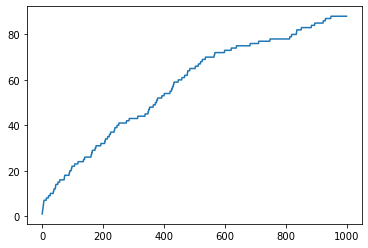

In [3]:
plt.plot(result)

In [ ]:
import PM_DMED

n_cores = 1
n_folds = 1
horizon = 100

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

outcome_distribution = [0.8,0.2]
job = (outcome_distribution, 1 )


game =  games.label_efficient(  ) 
game.set_outcome_distribution( {'spam':outcome_distribution[0],'ham':outcome_distribution[1]} )
print('optimal action', game.i_star)


# print('optimal action', game.i_star)
alg = cpb.CPB(  game, horizon,1.01) #TSPM.TSPM_alg(  game, horizon, 1)
task = Evaluation(horizon, 'easy')

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


In [58]:
import os


def loadall_results(path, horizon, n_folds):
    result = np.zeros( (n_folds, horizon) )
    with gzip.open(  path ,'rb') as f:
        for i in range(n_folds):
            try:
                result[i] = pkl.load(f)
            except EOFError:
                break
    return result


def loadall_results2(path, n_folds):
    result = np.zeros( (n_folds, 20000) )
    with gzip.open(  path ,'rb') as f:
        for i in range(n_folds):
            try:
                result[i] = pkl.load(f)[:20000]
            except EOFError:
                break
    return result

n_folds = 96
horizon = 20000

game = games.apple_tasting(False)

algos = [ None ]

colors = [  [160, 32, 240], [0,250,0], [250,0,0]  ] 

task = 'difficult'
name = 'AT'
context_type = 'quintic'
labels_latex = [ 'PGIDS', 'RandCBP', 'CBPside'  ] 
labels = [   'PGIDSratio', 'RandCBP', 'CBPside' ]

fig = go.Figure(    )

for color, label, label_latex in zip( colors, labels, labels_latex):

    r,g,b = color

    direct = './contextual_results/{}'.format(name)
    if label == 'RandCBP':
        path = os.path.join(direct, 'benchmark_{}_{}_100000_96_RandCBPside005_1_5_07.pkl.gz'.format(task,context_type) )
        result = loadall_results2(path, 96)

    elif label == 'CBPside':
        path = os.path.join(direct, '{}_{}_100000_96_CBPside005.pkl.gz'.format(task,context_type) )
        result = loadall_results2(path, 96)

    else: 
        path = os.path.join(direct, '{}_{}_{}_{}_{}.pkl.gz'.format(task,context_type, horizon, 15, label) )
        result = loadall_results(path, horizon, n_folds)

    worst_case = np.argmax( result[:,-1] )
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist() 
    upper_regret = result[worst_case]

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label_latex,legendgrouptitle_text='Algorithm',legendgroup='Algorithm'  )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba({},{},{},0)'.format(r,g,b)),   hoverinfo="skip",  showlegend=False )  )
    
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.05), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.update_yaxes(range=[0, 10] )
fig.show(legend=True)

# fig.write_image("./difficult_AT_quintic.pdf")


In [59]:
path = os.path.join(direct, '{}_{}_{}_{}_{}.pkl.gz'.format(task,context_type, horizon, 15, 'PGIDSratio') )
result = loadall_results(path, horizon, n_folds)
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
game_name = 'AT'
task = 'difficult'
context_type = 'quintic'
horizon = 20000
n_folds = 15
import subprocess
label ='PGIDSratio'

with gzip.open( './contextual_results/{}/{}_{}_{}_15_{}.pkl.gz'.format(game_name, task, context_type, horizon, label) ,'wb') as g:

    for jobid in [64,71,75,79,83,85,86,88,89,90,91,92,93,94,95]:

        with gzip.open(  './contextual_results/{}/{}_{}_{}_96_{}_{}.pkl.gz'.format(game_name, task, context_type, horizon, label, jobid) ,'rb') as f:
            r = pkl.load(f)

        pkl.dump( r, g)
                
        bashCommand = 'rm ./contextual_results/{}/{}_{}_{}_96_{}_{}.pkl.gz'.format(game_name, task, context_type, horizon, label, jobid)
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

FileNotFoundError: [Errno 2] No such file or directory: './contextual_results/AT/difficult_quintic_20000_96_PGIDSratio_64.pkl.gz'

In [10]:
res = []
for i in range(n_folds):
    opt = min(final_regrets[:,i])
    vec = [ j == opt for j in final_regrets[:,i] ] 
    #if vec[1]==1 and vec[2] == 1:
    #    pass
    #else:
    res.append(  vec  )

#print( np.sum( res,0) )

diff = []
for i in range(n_folds):
    if res[i][1] >= res[i][2]:
        diff.append( i )

np.random.seed(1)
distributions = []
for jobid in range(n_folds):
    p = np.random.uniform(0.4, 0.5) 
    distributions.append( [p, 1-p] )

distributions_rand = np.array([ distributions[i] for i in diff ])
distributions_cbp = np.array([ distributions[i] for i in range(n_folds) if i not in diff ])
#print( len( diff ) )
print(np.mean(distributions_rand[:,0]), np.std(distributions_rand[:,0]) )
print(np.mean(distributions_cbp[:,0]), np.std(distributions_cbp[:,0]) )


0.456154090331781 0.03132638699822154
0.43466197585846006 0.024706747598054565


In [ ]:
fig.update_xaxes(type="log")
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence (log-scale)", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./easy_LE_log.pdf")
fig.show()

In [5]:
fig.write_image("./easy_LE.pdf")

